# Selhání řešiče

Používání takto mocného nástroje jako je FEniCSx vede bohužel k tomu, že se až příliš utilizuje. Mnoho uživatelů ho používá jako blackbox. V této části si motivačně ukážeme, proč je důležité vnímat i teorii která je za tím vším. Musíme vědět, kdy naše postupy selhávají a proč. Zde poukážeme na možné problematické použití řešiče při využití v jistém smyslu nekonformních funkcí.

## Definice problému

Uvažujme problém vedení tepla na doméně $\langle 0,1\rangle$, kde na obou koncích předepisujeme dirichletovy okrajové podmínky a to $T(0)=0$ a $T(1)=1$. Dále uvažujme, že doména je tvořena dvojicí materiálů, které jsou na těsto spojené, ale každý z nich má jiný materiálový parametr $\lambda(x)$. Nejedná se o nereálný stav. Tato situace nastává například při zateplení fasády, kdy zdivo má jiný součinitel vodivosti nežli polystyren. Předpokládejme tedy např. že

$$
\lambda(x) = \begin{cases} 10,\quad x\in\langle 0,x_p), \\ 1,\quad x\in (x_p,1\rangle.\end{cases}
$$

Nakonec uvažujme (pro ukázku chování řešiče), že doménu budeme řešit za použití tří uzlových hodnot, resp. doménu rozdělíme na dva prvky. Vzhledem k okrajovým podmínkám máme tedy pouze jedinou uzlovou neznámou. Naše situace se dá tedy graficky popsat takto

:::{image} figs/fem_failex.png
:class: bg-primary mb-1
:width: 700px
:align: center
:::

Takový problém lze relativně jednoduše vyřešit v ruce. Přeskočme ukázku odvození analytického vztahu a rovnou prozraďme, že teorie tvrdí, že uzlová hodnota v bodě $x_2$ by se měla rovnat $T(x_2)=1/(20x_p + 2(1 - x_p)))$ v závislosti na zvolené poloze změny materiálu $x_p$.

Implementace takové úlohy je snadná a kopíruje kód představený v předchozí sekci. Možná zmiňme, že využívá knihovnu <code>ufl</code> pro analytický zýpis po částech konstantní funkce následovně

<code>xs = ufl.SpatialCoordinate(domain)</code>

<code>p = ufl.conditional(xs[0] < pos_i, 10, 1)</code>

První řádek slouží k vyvolání souřadného systému a na něj je vytvořena kondicionální funkce, která je rovna 10, když je souřadnice $x$ menší než proměnná <code>pos_i</code>, v opačném případě je rovna 1. V následujícím kódu je vytvořena utilitka, která spočte toto konečněprvkové řešení právě na zvolené poloze $x_p$, která je v kódu reprezentována zmíněnou proměnnou <code>pos_i</code>.

In [4]:
import dolfinx as dfx
from mpi4py import MPI
import matplotlib.pyplot as plt
import numpy as np
import ufl
import dolfinx.fem.petsc
from petsc4py.PETSc import ScalarType


# --------------------
# Classes and methods
# --------------------
def left(x):
    return np.isclose(x[0], 0)


def right(x):
    return np.isclose(x[0], 1)


def piecewise_constant_solver(pos_i, qd=0):
    # --------------------
    # Define geometry
    # --------------------
    domain = dfx.mesh.create_unit_interval(MPI.COMM_WORLD, 2)
    tdim = domain.topology.dim
    fdim = tdim - 1

    # --------------------
    # Define spaces
    # --------------------
    V = dfx.fem.FunctionSpace(domain, ("Lagrange", 1))

    x = V.tabulate_dof_coordinates()
    x_order = np.argsort(x[:, 0])

    # --------------------
    # Boundary conditions
    # --------------------
    left_dofs = dfx.fem.locate_dofs_geometrical(V, left)
    right_dofs = dfx.fem.locate_dofs_geometrical(V, right)

    bcs = [
        dfx.fem.dirichletbc(0.0, left_dofs, V),
        dfx.fem.dirichletbc(1.0, right_dofs, V),
    ]

    # --------------------
    # Initialization
    # --------------------
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)

    # --------------------
    # Weak form
    # --------------------
    xs = ufl.SpatialCoordinate(domain)
    p = ufl.conditional(xs[0] < pos_i, 10, 1)
    if qd > 0:
        dx = ufl.Measure("dx", metadata={"quadrature_degree": qd})
    else:
        dx = ufl.dx
    f = dfx.fem.Constant(domain, ScalarType(0.0))
    a = p*u.dx(0)*v.dx(0)*dx
    L = ufl.inner(f, v)*ufl.dx

    # --------------------
    # Solution
    # --------------------
    u_sol = dfx.fem.Function(V, name="Displacement")
    problem = dfx.fem.petsc.LinearProblem(
        a, L, u=u_sol, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
    )
    problem.solve()
    
    a_matrix = dfx.fem.assemble_matrix(dfx.fem.form(a))

    # Printing matrices
    # print("A matrix:\n", np.array_str(a_matrix.to_dense(), precision=3))

    # --------------------
    # Postprocess
    # --------------------
    plt.title("$x_p$={}".format(pos_i))
    plt.plot(x[x_order, 0], u_sol.x.array[x_order], "-", label="FEniCS")
    
    # Analytical solution
    xia = [0, 0.5, 1]
    yia = [0, 2/(40*pos_i + 4*(1-pos_i)), 1]
    plt.plot(xia, yia, "--", label="Analytické")
    plt.legend()
    plt.show()

Pokud řešič pustíme pro $x_p=0.5$, tak vše funguje dle očekávání:

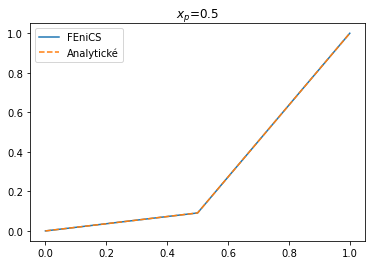

In [9]:
piecewise_constant_solver(0.5)

Nicméně pokud zkusíme menší hodnotu než 0.5, tak se řešič chová prapodivně:

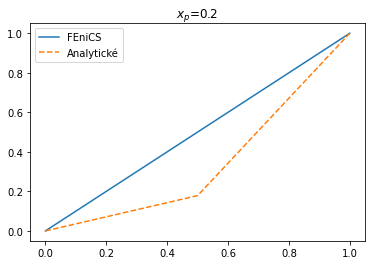

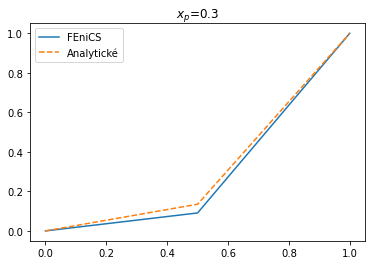

In [6]:
piecewise_constant_solver(0.2)
piecewise_constant_solver(0.3)

Pro $x_p=0.3$ dostáváme podobné řešení, které bychom měli. Nicméně pro $x_p=0.2$ je řešení z FEniCSx kvalitativně jiné, než očekávané. Důvod k tomuto chování není težké odhalit. FEniCSx při odvozování matic soustavy neintegruje analyticky, ale využívá k tomu Gaussovu kvadraturu, kde je potřeba nastavit stupeň integrace. Pro po částech lineární funkci stačí na každém intervalu vyčíslovat jen v jediném bodě (u nás v $x=0.25$ a $x=0.75$). Při použití složitějších funkcí je potřeba tento stupeň zvyšovat. Ve FEniCSx dojde k odhadu, jakou kvadraturu použít. Nicméně konstantní funkce měnící se skokově je obecně exaktně spočitatelná jen za předpokladu nekonečného množství Gaussových bodů, možná proto FEniCSx tento stupeň nezměnil a vyčísloval výrazy s kvadraturou stupně jedna. A to je jeden z důvodů proč doporučuji si všechny numerické parametry hlídat nebo je rovnou nastavovat bez ohledu na jakýkoliv automat. 

Vraťme se k našemu příkladu, kde je vidět, že pokud je nespojitost přesně uprostřed, dostáváme správné řešení. Je to tím, že každý prvek má sice jiný materiálový parametr, ale je zintegrován přesně za využití integračních bodů $x=0.25$ a $x=0.75$. Nicméně při umístění nespojitosti do $x_p=0.3$ dostáváme pořád tentýž výsledek. Při integraci prvního prvku řešič sahá pro materiálový parametr stále do $x=0.25$ a při integraci druhého prvku do $0.75$. Tedy materiálové složení tyče mu připadne stejné. Naopak při $x_p=0.2$ vyčíslí v těchto bodech tyč jako homogenní. 

Pojďme si to ukázat na našem příkladu, jak toto opravit. Námi definovaná funkce má ještě jeden volný parametr a to je <code>qd</code> neboli "quadrature degree", kterým můžeme uměle zvýšit množství bodů, pomocí kterých integrály vyčísluje. Tedy spusťme řešič opět pro $x_p=0.3$ a $x_p=0.2$ se stupněm integrace 30:

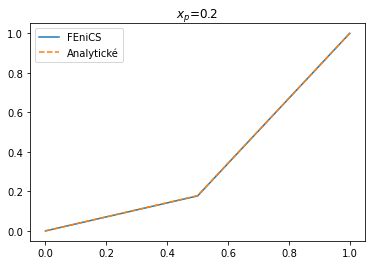

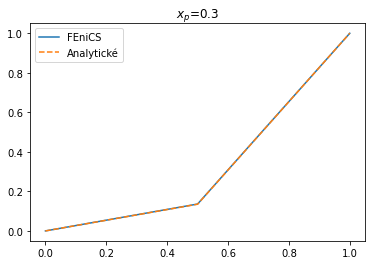

In [8]:
piecewise_constant_solver(0.2, qd=30)
piecewise_constant_solver(0.3, qd=30)

Je vidět, že řešič už se chová rozumněji. Tedy z tohoto příkladu by mělo plynout:
* Je důležité vnímat fungování řešiče a celou strukturu výpočtu, být schopen odhalit jeho chyby a nedostatky
* Je vhodné se trochu přizpůsobit zvolenému aproximačnímu prostoru. Pokud např. používáme skokově se měnící funkce, je vhodné cílit skok do uzlu sítě nebo přizpůsobit síť danému problému